# **Import thư viện**

| Loại mô hình | Mô hình   |
| ------------ | ------------- |
| **Purchase** | Random Forest |
| **Churn**    | LightGBM      |
| **CLV**      | XGBoost       |


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 674
[LightGBM] [Info] Number of data points in the train set: 99996, number of used features: 7
[LightGBM] [Info] Start training from score 6.931822


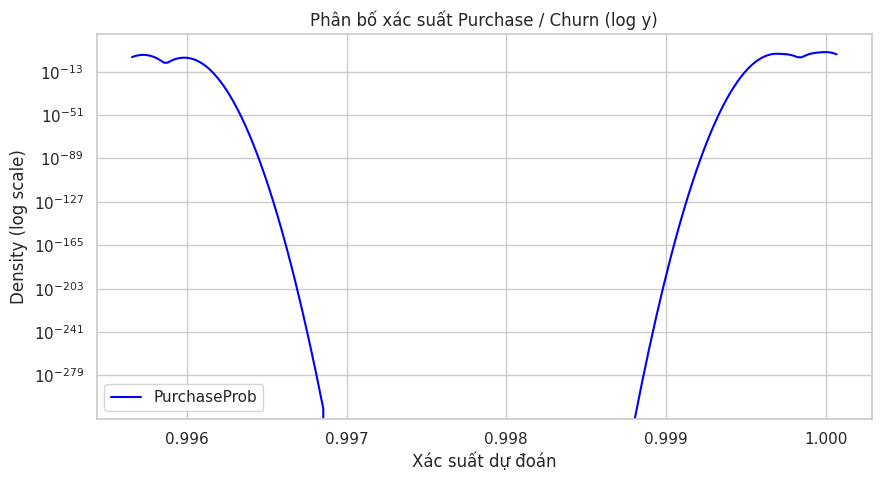

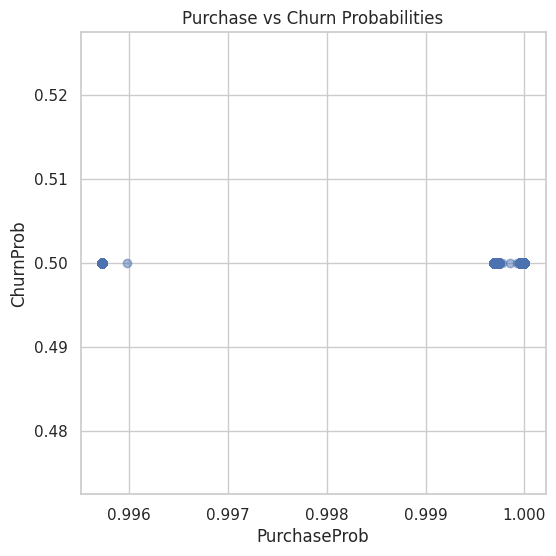

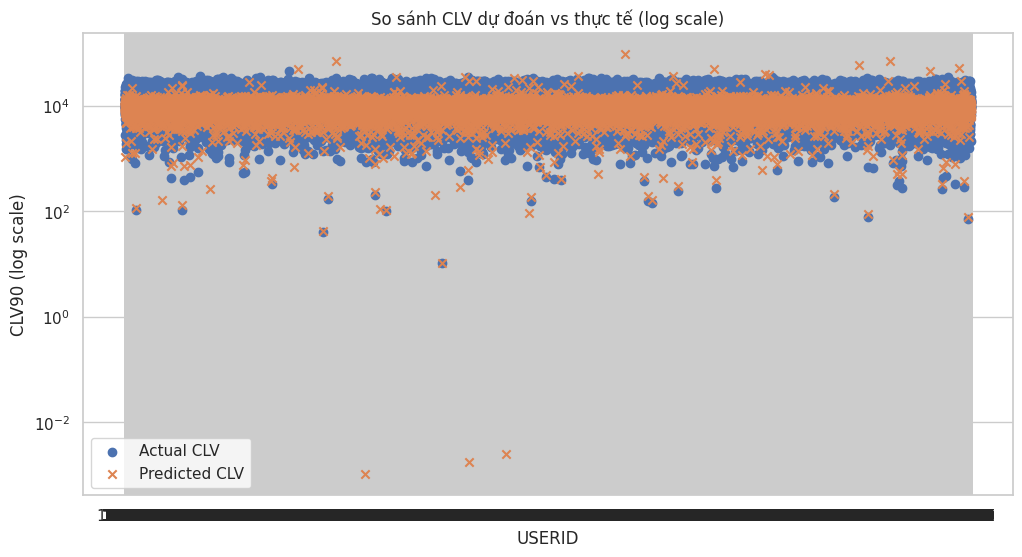

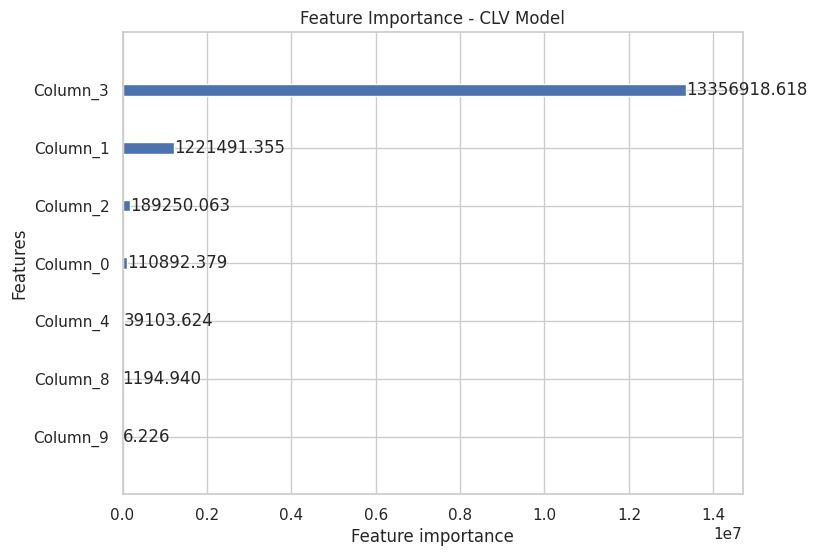

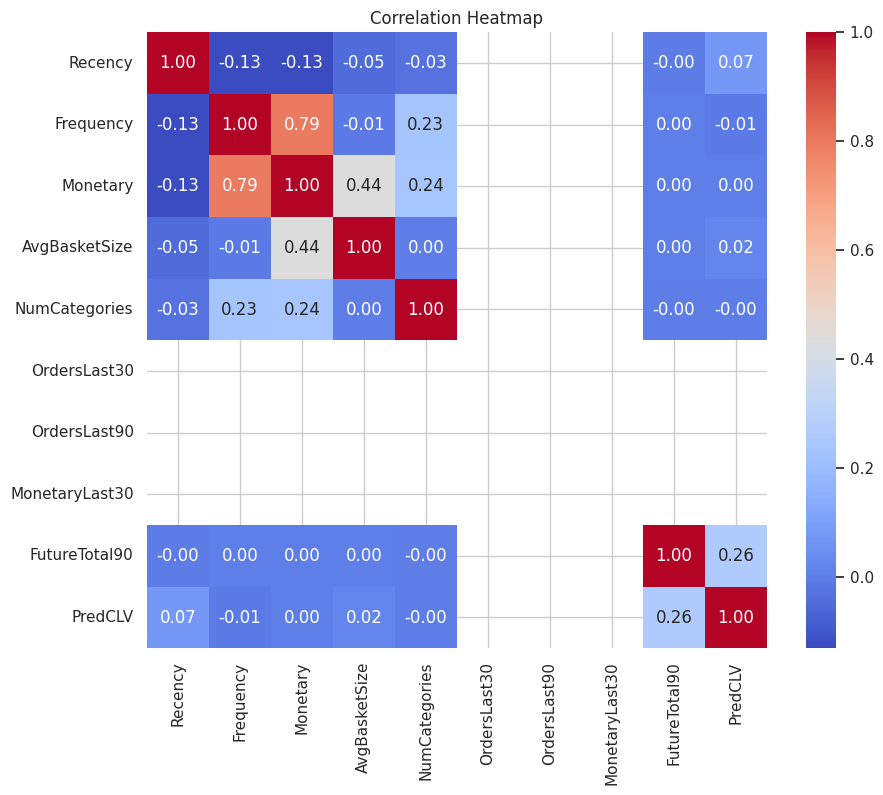

=== Purchase / Churn Metrics ===
Purchase ROC-AUC: 0.985
Churn ROC-AUC: 0.500

=== CLV Metrics ===
MAPE: 39.04% | SMAPE: 36.54% | RMSE: 5506.92


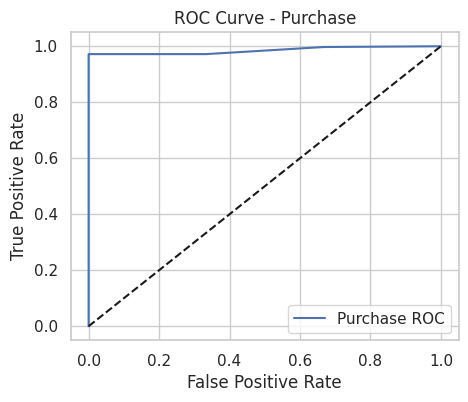

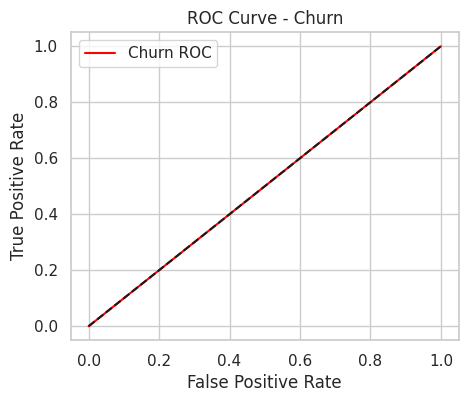

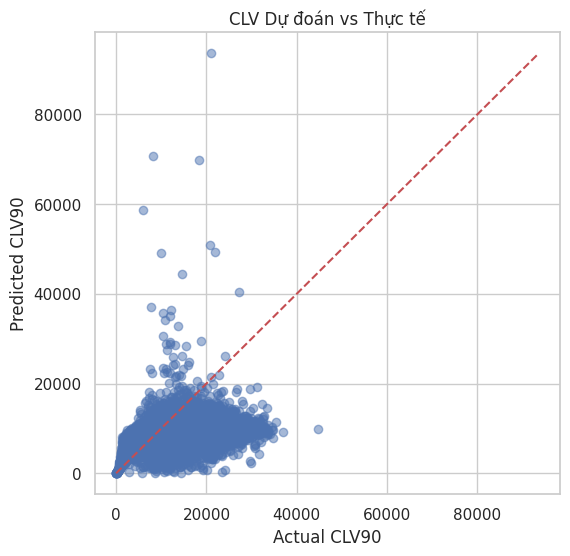

In [1]:
# ================================================================
# 0️⃣ Import thư viện
# ================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, roc_auc_score, mean_squared_error, mean_absolute_percentage_error, roc_curve
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")  
sns.set(style="whitegrid")          

# ================================================================
# 1️⃣ Đọc dữ liệu & giữ cột cần thiết
# ================================================================
data_path = "/kaggle/input/3a-superstore"

#  Đọc từng file CSV, chỉ giữ các cột cần thiết để giảm bộ nhớ
customers = pd.read_csv(f"{data_path}/Customers.csv", sep=";")[["USERID", "REGION"]]
orders = pd.read_csv(f"{data_path}/Orders.csv")[["ORDERID", "USERID", "DATE_", "TOTALBASKET"]]
order_details = pd.read_csv(f"{data_path}/Order_Details.csv")[["ORDERID", "ITEMID", "TOTALPRICE"]]
categories = pd.read_csv(f"{data_path}/Categories.csv")[["ITEMID", "CATEGORY1"]]

# ================================================================
# 2️⃣ Gộp dữ liệu
# ================================================================
#  Merge 4 bảng thành 1 dataset tổng hợp theo ORDERID, USERID, ITEMID
df = orders.merge(order_details, on="ORDERID", how="left") \
           .merge(categories, on="ITEMID", how="left") \
           .merge(customers, on="USERID", how="left")

# ================================================================
# 3️⃣ Chuyển kiểu dữ liệu & chuẩn hóa
# ================================================================
df["DATE_"] = pd.to_datetime(df["DATE_"], errors="coerce")  

#  Chuyển giá tiền từ string (dấu . hoặc ,) sang float
df["TOTALPRICE"] = df["TOTALPRICE"].astype(str).str.replace(".", "").str.replace(",", ".").astype(float)
df["TOTALBASKET"] = df["TOTALBASKET"].astype(str).str.replace(".", "").str.replace(",", ".").astype(float)

#  Đảm bảo các ID là string, tránh lỗi merge hoặc groupby
df[["USERID","ORDERID","ITEMID"]] = df[["USERID","ORDERID","ITEMID"]].astype(str)

#  Các cột phân loại chuyển sang category để tiết kiệm bộ nhớ
df["REGION"] = df["REGION"].astype("category")
df["CATEGORY1"] = df["CATEGORY1"].astype("category")

# ================================================================
# 4️⃣ Loại bỏ dữ liệu trùng lặp, thiếu, phi logic + winsorize
# ================================================================
df.drop_duplicates(subset=["USERID", "ORDERID", "ITEMID"], inplace=True)

#  Loại bỏ dòng bị thiếu dữ liệu quan trọng
df.dropna(subset=["USERID", "ORDERID", "DATE_", "TOTALBASKET", "ITEMID", "TOTALPRICE"], inplace=True)
df = df[(df["TOTALPRICE"] > 0) & (df["TOTALBASKET"] > 0)]
df = df[df["TOTALPRICE"] <= df["TOTALBASKET"]]

today = pd.Timestamp.today()
df = df[(df["DATE_"] > "2000-01-01") & (df["DATE_"] <= today)]

#  Winsorize 5% để giới hạn outlier (cắt trên 95% và dưới 5%)
for col in ["TOTALPRICE","TOTALBASKET"]:
    lower, upper = df[col].quantile([0.05,0.95])
    df[col] = np.clip(df[col], lower, upper)

# ================================================================
# 5️⃣ Lọc khách hàng có đơn hàng
# ================================================================
df = df.groupby("USERID").filter(lambda x: x["TOTALPRICE"].sum() > 0)

# ================================================================
# 6️⃣ Tạo RFM + features mở rộng
# ================================================================
#  Chọn mốc tham chiếu: 1 năm trước ngày cuối cùng trong dữ liệu
reference_date = df["DATE_"].max() - pd.Timedelta(days=365)

#  Chia dữ liệu thành quá khứ (1 năm trước) và tương lai (90 ngày sau)
past_df = df[df["DATE_"] <= reference_date].copy()
future_df = df[(df["DATE_"] > reference_date) & (df["DATE_"] <= reference_date + pd.Timedelta(days=90))].copy()

#  Tính toán các chỉ số RFM và một số đặc trưng khác
rfm = past_df.groupby("USERID").agg(
    Recency=("DATE_", lambda x: (reference_date - x.max()).days),  
    Frequency=("ORDERID", "nunique"),                              
    Monetary=("TOTALPRICE", "sum"),                                
    AvgBasketSize=("TOTALPRICE", "mean"),                         
    NumCategories=("CATEGORY1", "nunique"),                        
).reset_index()

#  Thêm các đặc trưng thời gian gần (30/90 ngày)
rfm['OrdersLast30'] = past_df[past_df['DATE_'] > reference_date - pd.Timedelta(days=30)] \
    .groupby('USERID')['ORDERID'].nunique().reindex(rfm['USERID'], fill_value=0)
rfm['OrdersLast90'] = past_df[past_df['DATE_'] > reference_date - pd.Timedelta(days=90)] \
    .groupby('USERID')['ORDERID'].nunique().reindex(rfm['USERID'], fill_value=0)
rfm['MonetaryLast30'] = past_df[past_df['DATE_'] > reference_date - pd.Timedelta(days=30)] \
    .groupby('USERID')['TOTALPRICE'].sum().reindex(rfm['USERID'], fill_value=0)

#  Tổng hợp thông tin mua trong tương lai 90 ngày
future_summary = future_df.groupby("USERID", as_index=False).agg(
    FutureOrders90=("ORDERID", "nunique"),
    FutureTotal90=("TOTALPRICE", "sum")
)
rfm = rfm.merge(future_summary, on="USERID", how="left").fillna(0)

# ================================================================
# 7️⃣ Tạo nhãn Purchase / Churn / CLV
# ================================================================
#  Nhãn xác suất mua trong tương lai (chuẩn hóa)
rfm["PurchaseProbLabel"] = rfm["FutureOrders90"]/ (rfm["FutureOrders90"].max() + 1e-6)

#  Nhãn churn ngược lại
rfm["ChurnProbLabel"] = 1 - rfm["PurchaseProbLabel"]

#  Giá trị CLV (log-scale) và giới hạn 95% để giảm outlier
rfm["CLV90_log"] = np.log1p(rfm["FutureTotal90"])
rfm["CLV90_capped"] = np.clip(rfm["FutureTotal90"], 0, rfm["FutureTotal90"].quantile(0.95))

# ================================================================
# 8️⃣ Phân cụm khách hàng (KMeans)
# ================================================================
features_rfm = ["Recency","Frequency","Monetary","AvgBasketSize","NumCategories","OrdersLast30","OrdersLast90","MonetaryLast30"]
scaler = StandardScaler()                
rfm_scaled = scaler.fit_transform(rfm[features_rfm])

#  Tìm số cụm tối ưu dựa trên silhouette score
best_score, best_k = -1, 2
for k in range(2,8):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(rfm_scaled)
    score = silhouette_score(rfm_scaled, labels)
    if score > best_score:
        best_score, best_k = score, k

#  Áp dụng KMeans với số cụm tối ưu
km = KMeans(n_clusters=best_k, random_state=42, n_init=10)
rfm['Cluster'] = km.fit_predict(rfm_scaled)

#  One-hot encode cụm để làm feature cho mô hình
rfm = pd.get_dummies(rfm, columns=["Cluster"], prefix="Cluster")

# ================================================================
# 9️⃣ Chuẩn bị dữ liệu model
# ================================================================
cluster_cols = [c for c in rfm.columns if c.startswith("Cluster_")]
X_scaled_features = scaler.transform(rfm[features_rfm])  
X_clusters = rfm[cluster_cols].values                    
X = np.hstack([X_scaled_features, X_clusters])
features_model = features_rfm + cluster_cols

# ================================================================
# 🔟 Hàm xây dựng mô hình phân loại xác suất (Purchase/Churn)
# ================================================================
def build_probabilistic_model(X, y, model_type="logistic"):
    #  Chọn model: Logistic hoặc RandomForest
    if model_type=="logistic":
        base = LogisticRegression(max_iter=500, class_weight='balanced')
    elif model_type=="rf":
        base = RandomForestClassifier(n_estimators=200, class_weight='balanced', n_jobs=-1)
    else:
        raise ValueError("model_type not supported")
    #  Dùng CalibratedClassifierCV để hiệu chỉnh xác suất (Isotonic)
    calibrated = CalibratedClassifierCV(base, method='isotonic', cv=3)
    calibrated.fit(X, y)
    return calibrated

#  Mô hình dự đoán xác suất mua lại
y_purchase = (rfm["FutureOrders90"] > 0).astype(int)
purchase_model = build_probabilistic_model(X, y_purchase, model_type="logistic")

#  Mô hình churn - xử lý mất cân bằng dữ liệu bằng undersampling
y_churn = (rfm["FutureOrders90"] == 0).astype(int)
X_major = X[y_churn==0]  
y_major = y_churn[y_churn==0]
X_minor = X[y_churn==1]  
y_minor = y_churn[y_churn==1]

#  Random undersampling nhóm majority
np.random.seed(42)
idx = np.random.choice(len(X_major), size=len(X_minor), replace=False)
X_major_under = X_major[idx]
y_major_under = y_major[idx]

#  Gộp và shuffle lại
X_res = np.vstack([X_major_under, X_minor])
y_res = np.hstack([y_major_under, y_minor])
perm = np.random.permutation(len(y_res))
X_res = X_res[perm]
y_res = y_res[perm]

#  Train mô hình churn
churn_model = build_probabilistic_model(X_res, y_res, model_type="rf")

#  Mô hình hồi quy CLV (LightGBM)
clv_model = lgb.LGBMRegressor(n_estimators=2000, learning_rate=0.05, random_state=42)
w = 1/(1 + rfm["CLV90_capped"].values)   #  Trọng số để giảm ảnh hưởng outlier
w /= np.mean(w)
clv_model.fit(X, rfm["CLV90_log"], sample_weight=w)

# ================================================================
# 11️⃣ Dự đoán cho từng khách hàng
# ================================================================
rfm['PurchaseProb'] = purchase_model.predict_proba(X)[:,1]   
rfm['ChurnProb'] = churn_model.predict_proba(X)[:,1]         
rfm['PredCLV'] = np.expm1(clv_model.predict(X))              

# ================================================================
# 12️⃣ Trực quan hóa nâng cao
# ================================================================
#  Phân bố xác suất Purchase và Churn
plt.figure(figsize=(10,5))
sns.kdeplot(rfm['PurchaseProb'], color='blue', label='PurchaseProb')
sns.kdeplot(rfm['ChurnProb'], color='red', label='ChurnProb')
plt.yscale('log')
plt.xlabel("Xác suất dự đoán")
plt.ylabel("Density (log scale)")
plt.title("Phân bố xác suất Purchase / Churn (log y)")
plt.legend()
plt.show()

#  Biểu đồ tương quan giữa xác suất mua và rời bỏ
plt.figure(figsize=(6,6))
plt.scatter(rfm['PurchaseProb'], rfm['ChurnProb'], alpha=0.5)
plt.xlabel("PurchaseProb"); plt.ylabel("ChurnProb")
plt.title("Purchase vs Churn Probabilities")
plt.show()

#  So sánh CLV thực tế và dự đoán
plt.figure(figsize=(12,6))
plt.scatter(rfm['USERID'], rfm['FutureTotal90'], label='Actual CLV', marker='o')
plt.scatter(rfm['USERID'], rfm['PredCLV'], label='Predicted CLV', marker='x')
plt.yscale('log')
plt.xlabel("USERID"); plt.ylabel("CLV90 (log scale)")
plt.title("So sánh CLV dự đoán vs thực tế (log scale)")
plt.legend()
plt.show()

#  Quan trọng của feature trong mô hình CLV
lgb.plot_importance(clv_model, max_num_features=10, importance_type='gain', figsize=(8,6))
plt.title("Feature Importance - CLV Model")
plt.show()

#  Ma trận tương quan giữa các đặc trưng chính và CLV
plt.figure(figsize=(10,8))
sns.heatmap(rfm[features_rfm + ['FutureTotal90','PredCLV']].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# ================================================================
# 13️⃣ Hàm đánh giá mô hình
# ================================================================
def smape(a, f):
    #  Hàm tính SMAPE (thước đo % sai lệch đối xứng)
    return np.mean(2*np.abs(f-a)/(np.abs(a)+np.abs(f)+1e-8))*100

def evaluate_model(rfm, future_df):
    #  Tính giá trị thực tế trong 90 ngày tương lai để so sánh
    actuals = future_df.groupby('USERID').agg(
        actual_orders=('ORDERID','nunique'),
        actual_total=('TOTALPRICE','sum')
    ).reset_index()
    #  Merge kết quả thực tế với dự đoán
    rfm_eval = rfm.merge(actuals, on='USERID', how='left').fillna(0)
    
    #  Xác định nhãn thực tế (purchase / churn)
    rfm_eval['ActualPurchase'] = (rfm_eval['actual_orders'] > 0).astype(int)
    rfm_eval['ActualChurn'] = (rfm_eval['actual_orders'] == 0).astype(int)
    
    #  Tính ROC-AUC cho purchase & churn
    purchase_auc = roc_auc_score(rfm_eval['ActualPurchase'], rfm_eval['PurchaseProb'])
    churn_auc = roc_auc_score(rfm_eval['ActualChurn'], rfm_eval['ChurnProb'])
    
    #  Đánh giá CLV bằng MAPE / SMAPE / RMSE
    clv_mape = mean_absolute_percentage_error(rfm_eval['actual_total']+1e-6, rfm_eval['PredCLV']+1e-6)*100
    clv_rmse = np.sqrt(mean_squared_error(rfm_eval['actual_total'], rfm_eval['PredCLV']))
    clv_smape_val = smape(rfm_eval['actual_total'], rfm_eval['PredCLV'])
    
    #  In kết quả
    print("=== Purchase / Churn Metrics ===")
    print(f"Purchase ROC-AUC: {purchase_auc:.3f}")
    print(f"Churn ROC-AUC: {churn_auc:.3f}")
    print("\n=== CLV Metrics ===")
    print(f"MAPE: {clv_mape:.2f}% | SMAPE: {clv_smape_val:.2f}% | RMSE: {clv_rmse:.2f}")
    
    #  Vẽ ROC curve cho Purchase
    fpr, tpr, _ = roc_curve(rfm_eval['ActualPurchase'], rfm_eval['PurchaseProb'])
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label='Purchase ROC')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - Purchase"); plt.legend(); plt.show()
    
    #  ROC curve cho Churn
    fpr, tpr, _ = roc_curve(rfm_eval['ActualChurn'], rfm_eval['ChurnProb'])
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label='Churn ROC', color='red')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - Churn"); plt.legend(); plt.show()
    
    #  Biểu đồ so sánh CLV thực tế vs dự đoán
    plt.figure(figsize=(6,6))
    plt.scatter(rfm_eval['actual_total'], rfm_eval['PredCLV'], alpha=0.5)
    max_val = max(rfm_eval['actual_total'].max(), rfm_eval['PredCLV'].max())
    plt.plot([0,max_val],[0,max_val],'r--')
    plt.xlabel("Actual CLV90"); plt.ylabel("Predicted CLV90")
    plt.title("CLV Dự đoán vs Thực tế"); plt.show()

# ================================================================
# 14️⃣ Test đánh giá mô hình
# ================================================================
evaluate_model(rfm, future_df)  


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy.stats.mstats import winsorize
from sklearn.dummy import DummyClassifier
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Phân cụm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Dự đoán Purchase Probability
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Dự đoán CLV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier
import lightgbm as lgb

# Dự đoán Churn
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/3a-superstore/Branches_ENG.csv
/kaggle/input/3a-superstore/Categories.csv
/kaggle/input/3a-superstore/Categories_ENG.csv
/kaggle/input/3a-superstore/Orders.csv
/kaggle/input/3a-superstore/Customers_ENG.csv
/kaggle/input/3a-superstore/Customers.csv
/kaggle/input/3a-superstore/Order_Details.csv
/kaggle/input/3a-superstore/Branches.csv


# **Load dữ liệu và xử lý**

In [2]:
# ================================================================
# 1️⃣ Đọc và giữ cột cần thiết
# ================================================================
data_path = "/kaggle/input/3a-superstore"

customers = pd.read_csv(f"{data_path}/Customers.csv", sep=";")[["USERID", "REGION"]]
orders = pd.read_csv(f"{data_path}/Orders.csv")[["ORDERID", "USERID", "DATE_", "TOTALBASKET"]]
order_details = pd.read_csv(f"{data_path}/Order_Details.csv")[["ORDERID", "ITEMID", "TOTALPRICE"]]
categories = pd.read_csv(f"{data_path}/Categories.csv")[["ITEMID", "CATEGORY1"]]

# ================================================================
# 2️⃣ Gộp dữ liệu
# ================================================================
df = (
    orders
    .merge(order_details, on="ORDERID", how="left")
    .merge(categories, on="ITEMID", how="left")
    .merge(customers, on="USERID", how="left")
)

# ================================================================
# 3️⃣ Chuyển kiểu dữ liệu & chuẩn hóa định dạng
# ================================================================
df["DATE_"] = pd.to_datetime(df["DATE_"], errors="coerce")

for col in ["TOTALBASKET", "TOTALPRICE"]:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace(".", "", regex=False)
        .str.replace(",", ".", regex=False)
        .astype(float)
    )

df["USERID"] = df["USERID"].astype(str)
df["ORDERID"] = df["ORDERID"].astype(str)
df["ITEMID"] = df["ITEMID"].astype(str)
df["REGION"] = df["REGION"].astype("category")
df["CATEGORY1"] = df["CATEGORY1"].astype("category")

# ================================================================
# 4️⃣ Loại bỏ trùng và thiếu dữ liệu quan trọng
# ================================================================
essential_cols = ["USERID", "ORDERID", "DATE_", "TOTALBASKET", "ITEMID", "TOTALPRICE"]
df.drop_duplicates(subset=["USERID", "ORDERID", "ITEMID"], inplace=True)
df.dropna(subset=essential_cols, inplace=True)

# ================================================================
# 5️⃣ Kiểm tra & loại bỏ giá trị logic sai
# ================================================================
# Giá <= 0 hoặc giỏ hàng <= 0 là bất hợp lý
df = df[(df["TOTALPRICE"] > 0) & (df["TOTALBASKET"] > 0)]
# Tổng giá từng item không vượt tổng giỏ hàng
df = df[df["TOTALPRICE"] <= df["TOTALBASKET"]]

# Ngày không hợp lệ (trong tương lai hoặc quá cũ)
today = pd.Timestamp.today()
df = df[(df["DATE_"] > "2000-01-01") & (df["DATE_"] <= today)]

# ================================================================
# 6️⃣ Xử lý ngoại lai nhẹ bằng winsorizing (cap nhẹ 1%)
# ================================================================
# Giữ lại extreme nhưng giảm ảnh hưởng noise
for col in ["TOTALPRICE", "TOTALBASKET"]:
    lower, upper = df[col].quantile([0.01, 0.99])
    df[col] = np.clip(df[col], lower, upper)

# ================================================================
# 7️⃣ Làm sạch khách hàng không có đơn hợp lệ
# ================================================================
df = df.groupby("USERID").filter(lambda x: x["TOTALPRICE"].sum() > 0)

# ================================================================
# 8️⃣ Kiểm tra nhanh dữ liệu sau làm sạch
# ================================================================
numeric_cols_orders = ["TOTALPRICE", "TOTALBASKET"]
display(df[numeric_cols_orders].describe().T.style.format("{:,.2f}"))

print("📊 Tổng số dòng:", len(df))
print("👥 Khách hàng duy nhất:", df["USERID"].nunique())
print("📅 Khoảng thời gian:", df["DATE_"].min().date(), "→", df["DATE_"].max().date())


,count,mean,std,min,25%,50%,75%,max
TOTALPRICE,"51,064,352.00",243.01,345.19,3.92,42.80,116.55,288.78,"2,031.75"
TOTALBASKET,"51,064,352.00","1,582.89","1,223.58",51.99,713.85,"1,285.73","2,109.16","6,395.10"


📊 Tổng số dòng: 51064352
👥 Khách hàng duy nhất: 99996
📅 Khoảng thời gian: 2021-01-01 → 2023-08-14


# **RFM**
* Recency (R): Khoảng cách thời gian từ lần mua cuối cùng đến hiện tại.

* Frequency (F): Số lượng đơn hàng trong khoảng thời gian.

* Monetary (M): Tổng chi tiêu của khách hàng.

In [3]:
reference_date = df["DATE_"].max() - pd.Timedelta(days=365)

# Dữ liệu quá khứ
past_df = df[df["DATE_"] <= reference_date].copy()

# Tạo RFM từ quá khứ
rfm = past_df.groupby("USERID").agg(
    Recency=("DATE_", lambda x: (reference_date - x.max()).days),
    Frequency=("ORDERID", "nunique"),
    Monetary=("TOTALPRICE", "sum"),
    AvgBasketSize=("TOTALPRICE", "mean"),
    NumCategories=("CATEGORY1", "nunique")
).reset_index()

# **Tạo nhãn dự đoán**

In [4]:
future_df = df[(df["DATE_"] > reference_date) & 
               (df["DATE_"] <= reference_date + pd.Timedelta(days=90))].copy()

future_summary = future_df.groupby("USERID", as_index=False).agg(
    FutureOrders90=("ORDERID", "nunique"),
    FutureTotal90=("TOTALPRICE", "sum")
)
rfm = rfm.merge(future_summary, on="USERID", how="left").fillna(0)
rfm["PurchaseNext90"] = (rfm["FutureOrders90"] > 0).astype(int)
rfm["Churn90"] = (rfm["FutureOrders90"] == 0).astype(int)

# CLV 90 ngày
rfm["Frequency_adj"] = rfm["Frequency"].replace(0,1)
rfm["CLV90_raw"] = rfm["FutureTotal90"]
rfm["CLV90_capped"] = np.clip(rfm["CLV90_raw"], 0, rfm["CLV90_raw"].quantile(0.99))
rfm["CLV90_log"] = np.log1p(rfm["CLV90_capped"])


In [5]:
print("PurchaseNext90 value counts:\n", rfm["PurchaseNext90"].value_counts())
print("Churn90 value counts:\n", rfm["Churn90"].value_counts())

PurchaseNext90 value counts:
 PurchaseNext90
1    99993
0        3
Name: count, dtype: int64
Churn90 value counts:
 Churn90
0    99993
1        3
Name: count, dtype: int64


# **Phân cụm**

In [6]:
features = ["Recency", "Frequency", "Monetary", "AvgBasketSize", "NumCategories"]
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[features])

best_score, best_k = -1, 2
for k in range(2, 8):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(rfm_scaled)
    score = silhouette_score(rfm_scaled, labels)
    if score > best_score:
        best_score, best_k = score, k

km = KMeans(n_clusters=best_k, random_state=42, n_init=10)
rfm["Cluster"] = km.fit_predict(rfm_scaled)

# One-hot encoding cluster
rfm = pd.get_dummies(rfm, columns=["Cluster"], prefix="Cluster")
features_model = features + [col for col in rfm.columns if col.startswith("Cluster_")]

print(f"✅ Chọn k={best_k} (silhouette={best_score:.3f})")
print(f"Features cho model: {features_model}")

✅ Chọn k=2 (silhouette=0.231)
Features cho model: ['Recency', 'Frequency', 'Monetary', 'AvgBasketSize', 'NumCategories', 'Cluster_0', 'Cluster_1']


In [7]:
scaler = StandardScaler()
scaler.fit(rfm[features_model])

StandardScaler()

# **MÔ HÌNH DỰ ĐOÁN**
* **Purchase Probability (Logistic Regression)**                : Dự đoán xác suất khách hàng sẽ mua trong kỳ tiếp theo.
* **CLV (Customer Lifetime Value, Gradient Boosting Regressor)**: Dự đoán giá trị vòng đời khách hàng, dựa trên các feature RFM.
* **Churn (Random Forest Classifier)**                          : Dự đoán xác suất khách hàng rời bỏ.

In [8]:
def build_purchase_model(rfm, features, scaler):
    X_scaled = scaler.transform(rfm[features])
    y = rfm["PurchaseNext90"]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.3, random_state=42, stratify=y
    )
    
    model = LogisticRegression(max_iter=500, class_weight='balanced')
    model.fit(X_train, y_train)
    
    return model, X_test, y_test

def build_clv_model(rfm, features, scaler):
    X_scaled = scaler.transform(rfm[features])
    y = rfm["CLV90_log"]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.3, random_state=42
    )
    
    w = 1 / (1 + rfm.loc[y_train.index, "CLV90_capped"].values)
    w = w / np.mean(w)
    
    model = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.03, random_state=42)
    model.fit(X_train, y_train, sample_weight=w)
    
    return model, X_test, y_test

def build_churn_model(rfm, features, scaler):
    X_scaled = scaler.transform(rfm[features])
    y = rfm["Churn90"]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.3, random_state=42, stratify=y
    )
    
    model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced', n_jobs=-1)
    model.fit(X_train, y_train)
    
    return model, X_test, y_test

purchase_model, X_purchase_test, y_purchase_test = build_purchase_model(rfm, features_model, scaler)
clv_model, X_clv_test, y_clv_test = build_clv_model(rfm, features_model, scaler)
churn_model, X_churn_test, y_churn_test = build_churn_model(rfm, features_model, scaler)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 69997, number of used features: 7
[LightGBM] [Info] Start training from score 6.088074



📊 KẾT QUẢ DỰ ĐOÁN CHO USER 80281 (90 ngày tới)
🛍️ PurchaseNext90: Prob=100.00% | Thực tế=1, Accuracy=✅
💰 CLV90: Dự đoán=10,583 | Thực tế=11,710
   ├─ MAPE=9.62% | SMAPE=10.11% | RMSE=1126.88
   └─ (log-scale) MAPE=1.08% | RMSE=0.10
⚠️ Churn90: Prob=0.00% | Thực tế=0, Accuracy=✅


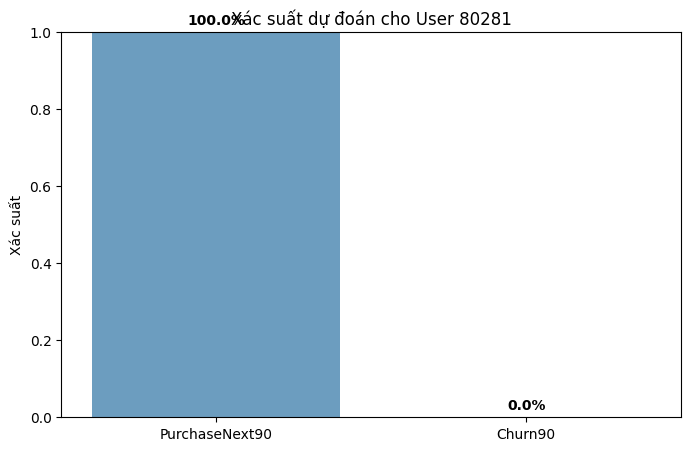

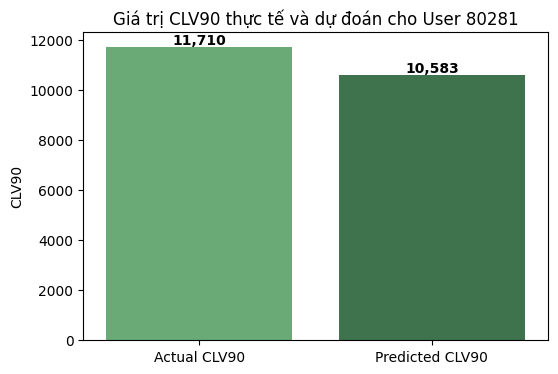

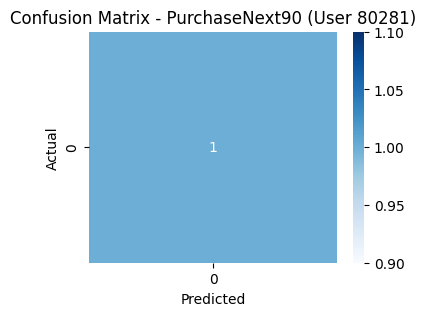

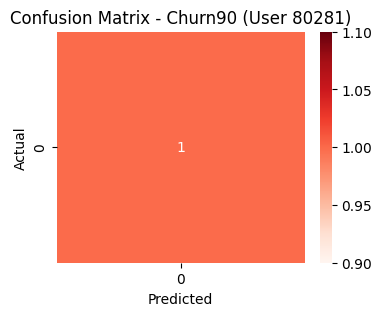

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 🔹 Chọn user
sample_userid = random.choice(rfm['USERID'].tolist())
# sample_userid = 91324
sample_user = rfm[rfm["USERID"] == sample_userid].copy()

# 🔹 Thêm các cột Cluster thiếu nếu user chỉ có 1 số cluster
for col in [c for c in rfm.columns if c.startswith("Cluster_")]:
    if col not in sample_user.columns:
        sample_user[col] = 0

# 🔹 Dự đoán
X_sample = scaler.transform(sample_user[features_model])

purchase_prob = purchase_model.predict_proba(X_sample)[0][1]
pred_log_clv = clv_model.predict(X_sample)[0]
pred_clv = np.expm1(pred_log_clv)

if len(churn_model.classes_) == 1:
    only_class = churn_model.classes_[0]
    churn_prob = 1.0 if only_class == 1 else 0.0
else:
    churn_prob = churn_model.predict_proba(X_sample)[0][1]

# 🔹 Thực tế
def smape(a, f):
    return np.mean(2 * np.abs(f - a) / (np.abs(a) + np.abs(f) + 1e-8)) * 100

future_actual = future_df[future_df["USERID"] == sample_userid]
if not future_actual.empty:
    actual_orders = future_actual["ORDERID"].nunique()
    actual_total = future_actual["TOTALPRICE"].sum()
else:
    actual_orders, actual_total = 0, 0

# Nhãn dự đoán
actual_purchase = int(actual_orders > 0)
actual_churn = int(actual_orders == 0)
purchase_label = int(purchase_prob >= 0.5)
churn_label = int(churn_prob >= 0.5)

purchase_acc = "✅" if purchase_label == actual_purchase else "❌"
churn_acc = "✅" if churn_label == actual_churn else "❌"

# MAPE & RMSE
purchase_mape = mean_absolute_percentage_error([actual_purchase], [purchase_prob]) * 100
clv_mape = mean_absolute_percentage_error([actual_total + 1e-6], [pred_clv + 1e-6]) * 100
clv_smape = smape(actual_total, pred_clv)
clv_rmse = np.sqrt(mean_squared_error([actual_total], [pred_clv]))
log_mape = mean_absolute_percentage_error([np.log1p(actual_total)], [pred_log_clv]) * 100
log_rmse = np.sqrt(mean_squared_error([np.log1p(actual_total)], [pred_log_clv]))

# 🔹 In kết quả
print(f"\n📊 KẾT QUẢ DỰ ĐOÁN CHO USER {sample_userid} (90 ngày tới)")
print(f"🛍️ PurchaseNext90: Prob={purchase_prob*100:.2f}% | Thực tế={actual_purchase}, Accuracy={purchase_acc}")
print(f"💰 CLV90: Dự đoán={pred_clv:,.0f} | Thực tế={actual_total:,.0f}")
print(f"   ├─ MAPE={clv_mape:.2f}% | SMAPE={clv_smape:.2f}% | RMSE={clv_rmse:.2f}")
print(f"   └─ (log-scale) MAPE={log_mape:.2f}% | RMSE={log_rmse:.2f}")
print(f"⚠️ Churn90: Prob={churn_prob*100:.2f}% | Thực tế={actual_churn}, Accuracy={churn_acc}")

# ===============================
# 1️⃣ Biểu đồ xác suất Purchase và Churn
# ===============================
plt.figure(figsize=(8,5))
probs = [purchase_prob, churn_prob]
labels = ["PurchaseNext90", "Churn90"]

sns.barplot(x=labels, y=probs, palette="Blues_d")
plt.ylim(0,1)
for i, v in enumerate(probs):
    plt.text(i, v + 0.02, f"{v*100:.1f}%", ha='center', fontweight='bold')
plt.title(f"Xác suất dự đoán cho User {sample_userid}")
plt.ylabel("Xác suất")
plt.show()

# ===============================
# 2️⃣ So sánh CLV dự đoán vs thực tế
# ===============================
plt.figure(figsize=(6,4))
sns.barplot(x=["Actual CLV90", "Predicted CLV90"], y=[actual_total, pred_clv], palette="Greens_d")
for i, v in enumerate([actual_total, pred_clv]):
    plt.text(i, v + max([actual_total, pred_clv])*0.01, f"{v:,.0f}", ha='center', fontweight='bold')
plt.title(f"Giá trị CLV90 thực tế và dự đoán cho User {sample_userid}")
plt.ylabel("CLV90")
plt.show()

Purchase Accuracy: 98.93%
Churn Accuracy: 100.00%
CLV MAPE: 51.94%, SMAPE: 42.20%, RMSE: 7069.49


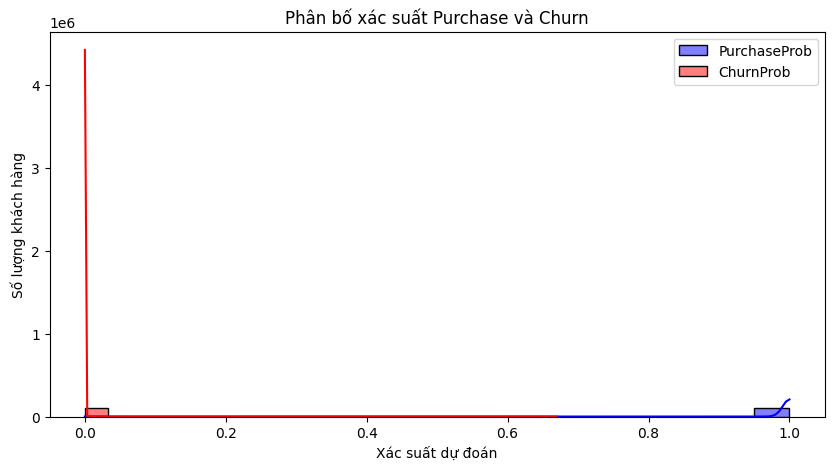

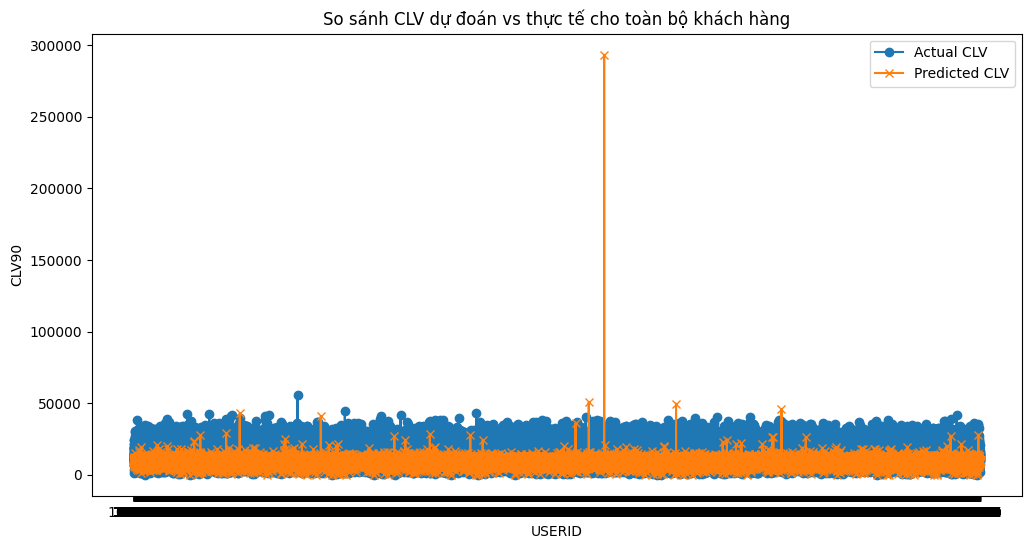

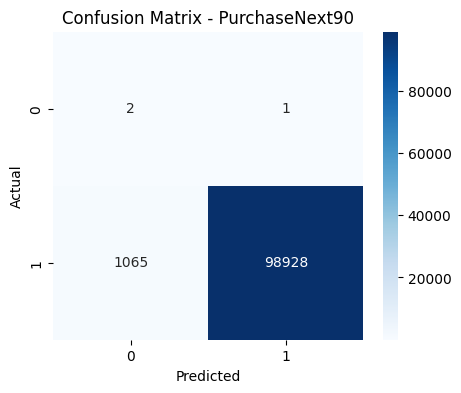

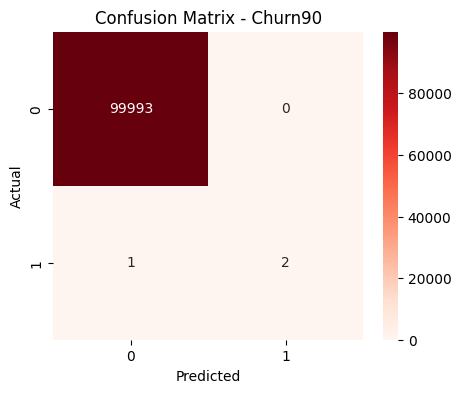

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, mean_absolute_percentage_error

def smape(a, f):
    return np.mean(2 * np.abs(f - a) / (np.abs(a) + np.abs(f) + 1e-8)) * 100

# 🔹 Dự đoán toàn bộ khách hàng
X_all = scaler.transform(rfm[features_model])
rfm['PurchaseProb'] = purchase_model.predict_proba(X_all)[:,1]
rfm['PredLogCLV'] = clv_model.predict(X_all)
rfm['PredCLV'] = np.expm1(rfm['PredLogCLV'])

if len(churn_model.classes_) == 1:
    only_class = churn_model.classes_[0]
    rfm['ChurnProb'] = 1.0 if only_class == 1 else 0.0
else:
    rfm['ChurnProb'] = churn_model.predict_proba(X_all)[:,1]

# 🔹 Nhãn dự đoán dựa trên ngưỡng 0.5
rfm['PurchaseLabel'] = (rfm['PurchaseProb'] >= 0.5).astype(int)
rfm['ChurnLabel'] = (rfm['ChurnProb'] >= 0.5).astype(int)

# 🔹 Lấy thực tế từ future_df
actuals = future_df.groupby('USERID').agg(
    actual_orders=('ORDERID','nunique'),
    actual_total=('TOTALPRICE','sum')
).reset_index()

rfm = rfm.merge(actuals, on='USERID', how='left')
rfm[['actual_orders','actual_total']] = rfm[['actual_orders','actual_total']].fillna(0)

rfm['ActualPurchase'] = (rfm['actual_orders'] > 0).astype(int)
rfm['ActualChurn'] = (rfm['actual_orders'] == 0).astype(int)

# 🔹 Metrics tổng hợp
purchase_acc = accuracy_score(rfm['ActualPurchase'], rfm['PurchaseLabel'])
churn_acc = accuracy_score(rfm['ActualChurn'], rfm['ChurnLabel'])
clv_mape = mean_absolute_percentage_error(rfm['actual_total'] + 1e-6, rfm['PredCLV'] + 1e-6) * 100
clv_smape = smape(rfm['actual_total'], rfm['PredCLV'])
clv_rmse = np.sqrt(mean_squared_error(rfm['actual_total'], rfm['PredCLV']))

print(f"Purchase Accuracy: {purchase_acc*100:.2f}%")
print(f"Churn Accuracy: {churn_acc*100:.2f}%")
print(f"CLV MAPE: {clv_mape:.2f}%, SMAPE: {clv_smape:.2f}%, RMSE: {clv_rmse:.2f}")

# ===============================
# 1️⃣ Biểu đồ phân bố xác suất Purchase / Churn
# ===============================
plt.figure(figsize=(10,5))
sns.histplot(rfm['PurchaseProb'], bins=20, color='blue', label='PurchaseProb', kde=True)
sns.histplot(rfm['ChurnProb'], bins=20, color='red', label='ChurnProb', kde=True)
plt.xlabel("Xác suất dự đoán")
plt.ylabel("Số lượng khách hàng")
plt.title("Phân bố xác suất Purchase và Churn")
plt.legend()
plt.show()

# ===============================
# 2️⃣ So sánh CLV dự đoán vs thực tế
# ===============================
plt.figure(figsize=(12,6))
plt.plot(rfm['USERID'], rfm['actual_total'], label='Actual CLV', marker='o')
plt.plot(rfm['USERID'], rfm['PredCLV'], label='Predicted CLV', marker='x')
plt.xlabel("USERID")
plt.ylabel("CLV90")
plt.title("So sánh CLV dự đoán vs thực tế cho toàn bộ khách hàng")
plt.legend()
plt.show()

# ===============================
# 3️⃣ Confusion matrix tổng hợp
# ===============================
cm_purchase = confusion_matrix(rfm['ActualPurchase'], rfm['PurchaseLabel'])
cm_churn = confusion_matrix(rfm['ActualChurn'], rfm['ChurnLabel'])

plt.figure(figsize=(5,4))
sns.heatmap(cm_purchase, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix - PurchaseNext90")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

plt.figure(figsize=(5,4))
sns.heatmap(cm_churn, annot=True, fmt='d', cmap="Reds")
plt.title("Confusion Matrix - Churn90")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


-----
------
-----

